In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os 
from pathlib import Path
import matplotlib.pyplot as plt

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
#setting Path
image_dir = Path('/content/gdrive/My Drive/Fish4Knowledge')
#get filepaths of all files
filepaths = list(image_dir.glob(r'**/*.png'))

In [6]:
data = []
#To get filepaths and label
for i in range(len(filepaths)):
    label = os.path.split(os.path.split(filepaths[i])[0])[1]
    data.append([str(filepaths[i]), label])

#creating DataFrame
df = pd.DataFrame(data, columns=['path', 'label'])
#droping Non Ground truths
df = df[df['label'].apply(lambda x: x[0:4] != "mask")].reset_index(drop = True)

In [7]:
#classes
df.label.unique()

array(['fish_23', 'fish_02', 'fish_22', 'fish_21', 'fish_20', 'fish_19',
       'fish_18', 'fish_17', 'fish_16', 'fish_15', 'fish_14', 'fish_13',
       'fish_12', 'fish_11', 'fish_10', 'fish_09', 'fish_08', 'fish_07',
       'fish_06', 'fish_05', 'fish_01', 'fish_03', 'fish_04'],
      dtype=object)

In [8]:
#getting 9 images of each class
fish_all = list(df.path.loc[0:8]) + list(df.path.loc[1000:1008]) + list(df.path.loc[2000:2008]) + list(df.path.loc[3000:3008]) + list(df.path.loc[4000:4008]) +list(df.path.loc[5000:5008]) + list(df.path.loc[6000:6008]) + list(df.path.loc[7000:7008]) + list(df.path.loc[8000:8008])

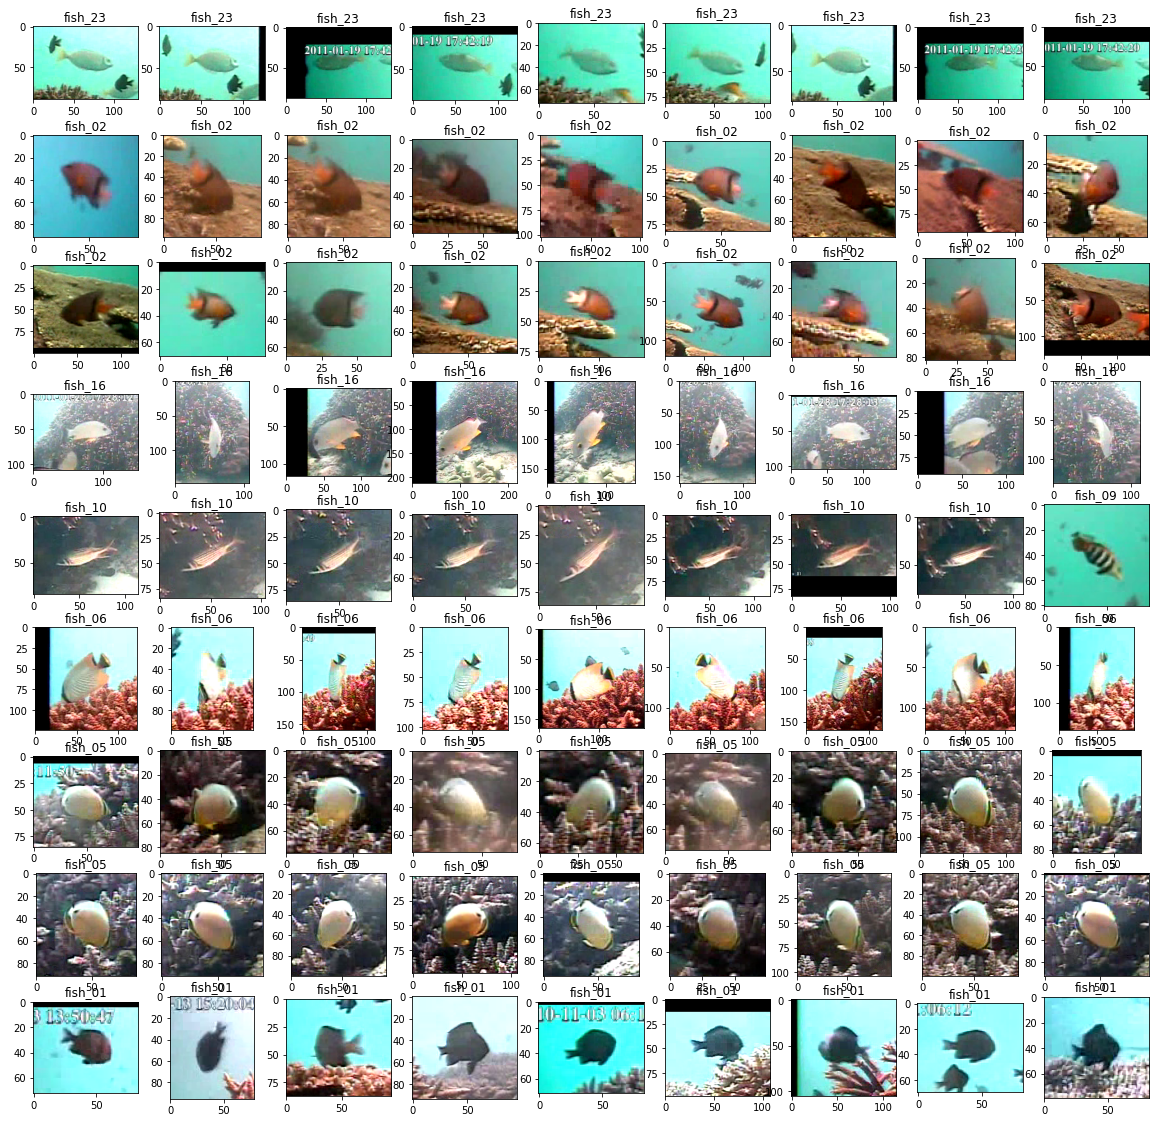

In [9]:
#A pyPlot for all class Images
fig, axes = plt.subplots(nrows = 9, ncols = 9, figsize = (20,20))
for index, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(fish_all[index]))
    ax.set_title(os.path.split(os.path.split(fish_all[index])[0])[1])

In [10]:
#checking Null values
df.isnull().any()

path     False
label    False
dtype: bool

In [11]:
#Dividing Data into Train, Test, and Validation
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size = 0.1, random_state = 42)
train_data.count()
test_data.count()

path     2740
label    2740
dtype: int64

In [12]:
from keras.preprocessing.image import ImageDataGenerator
#Handling Image data Generators
train_data_gen = ImageDataGenerator(validation_split=0.25)
test_data_gen = ImageDataGenerator()

train_imgs = train_data_gen.flow_from_dataframe(dataframe=train_data, x_col='path', y_col='label', target_size=(200,200),class_mode="categorical", color_mode='grayscale',batch_size=24, shuffle=True,subset="training")
val_imgs = train_data_gen.flow_from_dataframe(dataframe=train_data, x_col='path', y_col='label', target_size=(200,200), class_mode="categorical", color_mode='grayscale',batch_size=24, shuffle=True,subset="validation")

test_imgs = test_data_gen.flow_from_dataframe(dataframe=test_data,x_col='path', y_col='label', target_size=(200,200), class_mode="categorical", color_mode='grayscale',batch_size=24, shuffle=False)

Found 18494 validated image filenames belonging to 23 classes.
Found 6164 validated image filenames belonging to 23 classes.
Found 2740 validated image filenames belonging to 22 classes.


In [13]:
from keras import models,Input
from keras.models import Sequential, Model
from keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten,MaxPooling2D, InputLayer
from keras.layers import Dense, GlobalAveragePooling2D, Activation, Reshape, Permute, Multiply
from keras.utils.vis_utils import plot_model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 200, 200, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 200, 200, 32  0           ['conv2d[0][0]']                 
                                )                                                             

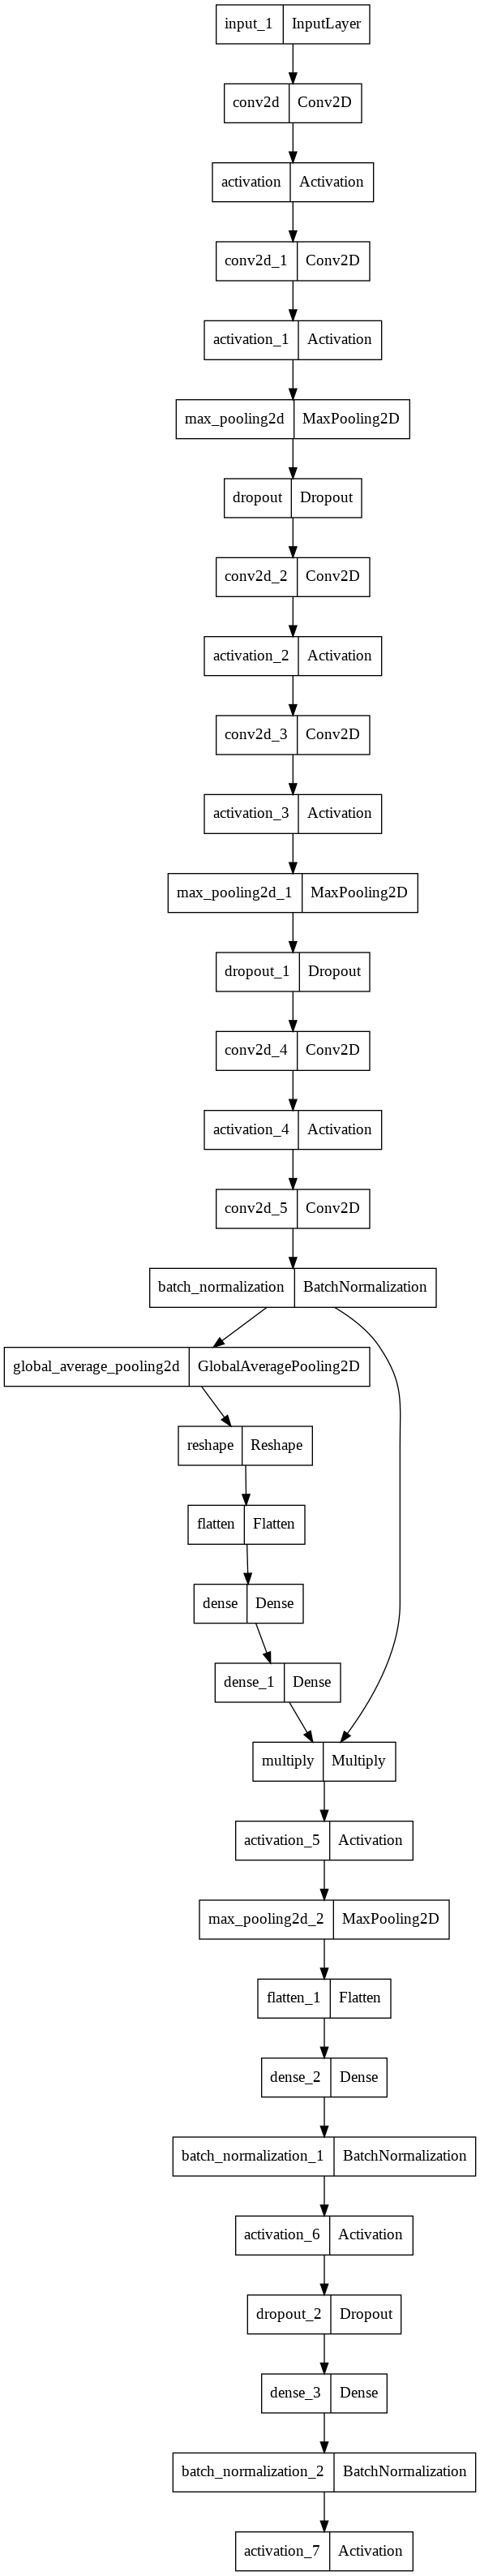

In [14]:
#CNN

inputLay = Input(shape=(200,200,1))
x = Conv2D(32, (3,3), padding='same')(inputLay)
x = Activation('relu')(x)
x = Conv2D(32, (3,3), padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.3)(x)

x = Conv2D(64, (3,3), padding='same')(x)
x = Activation('relu')(x)
x = Conv2D(64, (3,3), padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.3)(x)

x = Conv2D(128, (3,3), padding='same')(x)
x = Activation('relu')(x)
x = Conv2D(128, (3,3), padding='same')(x)

x = BatchNormalization()(x)

#SE Block
#inio Squeeze 
y = GlobalAveragePooling2D()(x)
y = Reshape((1,1,128))(y)
y = Flatten()(y)
#FC layer1
y = Dense(units=8,activation="relu")(y)

#Excitation
y = Dense(units=128,activation="sigmoid")(y)

x = Multiply()([x, y])

x = Activation('relu')(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)
x = Dense(23)(x)
x = BatchNormalization()(x)
outputLay = Activation('softmax')(x)

model = Model(inputLay, outputLay)

model.summary()
plot_model(model, to_file='model.png')

In [15]:
from tensorflow.keras.optimizers import *
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics = ['accuracy', 'AUC'])

In [16]:
history = model.fit( train_imgs, validation_data=val_imgs, epochs=5)

Epoch 1/5
771/771 [==============================] - 13796s 18s/step - loss: 1.3506 - accuracy: 0.7808 - auc: 0.9674 - val_loss: 1.2261 - val_accuracy: 0.7284 - val_auc: 0.9552
Epoch 2/5
771/771 [==============================] - 170s 220ms/step - loss: 0.6248 - accuracy: 0.9005 - auc: 0.9936 - val_loss: 0.8065 - val_accuracy: 0.7734 - val_auc: 0.9805
Epoch 3/5
771/771 [==============================] - 171s 222ms/step - loss: 0.3729 - accuracy: 0.9347 - auc: 0.9978 - val_loss: 0.5227 - val_accuracy: 0.8957 - val_auc: 0.9945
Epoch 4/5
771/771 [==============================] - 171s 222ms/step - loss: 0.2383 - accuracy: 0.9591 - auc: 0.9991 - val_loss: 0.3640 - val_accuracy: 0.9276 - val_auc: 0.9970
Epoch 5/5
771/771 [==============================] - 171s 222ms/step - loss: 0.1581 - accuracy: 0.9756 - auc: 0.9997 - val_loss: 0.2062 - val_accuracy: 0.9580 - val_auc: 0.9981


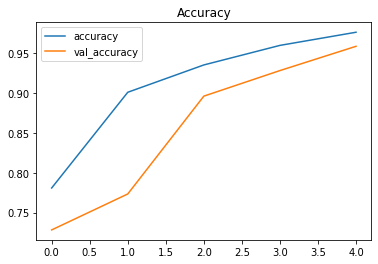

In [17]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

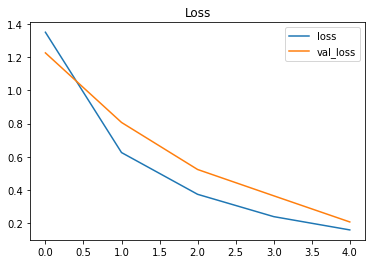

In [18]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title("Loss")
plt.show()

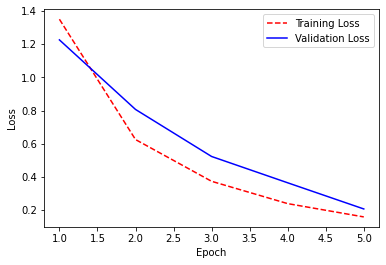

In [43]:
training_loss = history.history['loss']
valid_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, valid_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [19]:
prediction = model.predict(test_imgs)

In [60]:
output = np.argmax(prediction, axis=1)
labels = test_imgs.class_indices
print(labels)
print(type(labels))
pred_labels = dict((v,k) for k,v in labels.items())
print(pred_labels)
print(type(pred_labels))

{'fish_01': 0, 'fish_02': 1, 'fish_03': 2, 'fish_04': 3, 'fish_05': 4, 'fish_06': 5, 'fish_07': 6, 'fish_08': 7, 'fish_09': 8, 'fish_10': 9, 'fish_11': 10, 'fish_12': 11, 'fish_13': 12, 'fish_14': 13, 'fish_15': 14, 'fish_16': 15, 'fish_17': 16, 'fish_18': 17, 'fish_19': 18, 'fish_20': 19, 'fish_22': 20, 'fish_23': 21}
<class 'dict'>
{0: 'fish_01', 1: 'fish_02', 2: 'fish_03', 3: 'fish_04', 4: 'fish_05', 5: 'fish_06', 6: 'fish_07', 7: 'fish_08', 8: 'fish_09', 9: 'fish_10', 10: 'fish_11', 11: 'fish_12', 12: 'fish_13', 13: 'fish_14', 14: 'fish_15', 15: 'fish_16', 16: 'fish_17', 17: 'fish_18', 18: 'fish_19', 19: 'fish_20', 20: 'fish_22', 21: 'fish_23'}
<class 'dict'>


In [48]:
print(len(pred_labels))

22


In [64]:
print(len(output))

2740


In [63]:
labeled_pred = []
for i in range(0, len(output)):
    labeled_pred.append(pred_labels[output[i]])
    
    

KeyError: ignored

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

In [59]:
print(classification_report(test_data['label'], labeled_pred))
print(confusion_matrix(test_data.label, labeled_pred))

ValueError: ignored

In [ ]:
#model.evaluate(test_imgs)[1]
from sklearn.metrics import accuracy_score
print(accuracy_score(test_data.label, labeled_pred))

0.8967153284671533
